In [1]:
# Only bp on weight matrix, to find out what the final solution should be like
# Do backprop on each datapoint, better than backprop for each epoch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
# from training_abb05_wt import SimpleNeuralNetwork
from tqdm.notebook import tqdm

### Model

In [3]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, init_gain, init_shift, init_weight):
        super(SimpleNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.gain = torch.tensor(init_gain, dtype=torch.float32)
        self.shift = torch.tensor(init_shift, dtype=torch.float32)
        self.weights = torch.tensor(init_weight, dtype=torch.float32, requires_grad=True)
        # self.activation_func = nn.Sigmoid()
        self.activation_func = lambda x: 1 / (1.0 + torch.exp(-x))
        self.output_activation_func = lambda x: 1 / (1.0 + torch.exp(-x))
        self.gainout = 6.67
        self.shiftout = 1.035

        # just to record
        self.init_gain = torch.tensor(3 * np.ones((self.input_size, 1)), dtype=torch.float32)
        self.init_shift = torch.tensor(1 * np.ones((self.input_size, 1)), dtype=torch.float32)
        self.epoch = 0
    
    def normal_pdf(self, theta):
        # return 1.5 * torch.exp(-0.5 * (theta**2)) - 0.5
        return torch.exp(-0.5 * (theta**2))

    def gaussian_rf(self, x):
        theta_is = torch.linspace(0, 2 * torch.pi, self.input_size).view(-1,1)
        return self.normal_pdf(x - theta_is) + self.normal_pdf(x - theta_is + 2 * torch.pi) + self.normal_pdf(x - theta_is - 2 * torch.pi)

    def forward(self, x):
        x1 = self.gaussian_rf(x)
        self.input_activation = self.activation_func(self.gain * (x1 - self.shift)+0.1)
        x2 = torch.matmul(self.weights, self.input_activation)
        self.output_activation = self.output_activation_func(self.gainout * (x2 - self.shiftout))
        # self.output_activation = x2.clone()  # linear acitvation func
        return self.output_activation

### Hebbian Coverge Test

Unfortunatelly, the Hebbian learning rule does not converge to the correct weights. The weights tend to flatten to a certain small curvature. This final convergence does not depend on hebbian learning rate.

In [4]:
ndata = 100
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [5]:
# # hebbian update in total
# simu_epochs = 100
# input_size = 230
# init_gain = model_wt.gain.detach().numpy()
# init_shift = model_wt.shift.detach().numpy()
# init_weight = model_wt.weights.detach().numpy()
# # init_weight = np.random.rand(1, input_size)
# has_hebbian = True
# hebbian_lr = 0.001
# hebb_alpha = 5

# simu_losses = []
# simu_weight_sums = []

# for epoch in tqdm(range(simu_epochs), position=0, leave=True):

#     # shuffle data
#     perm_idx = torch.randperm(ndata)
#     shuffled_xs = xs[perm_idx]
#     shuffled_ys = ys[perm_idx]

#     epoch_loss = 0
#     hebbian_update = torch.zeros_like(torch.tensor(init_weight))

#     # establish model
#     model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

#     for x, y in zip(shuffled_xs, shuffled_ys):            
#         actv_opl = model(x)
#         output = actv_opl.squeeze()
#         # Calculate loss
#         loss_func = nn.MSELoss()
#         loss = 0.5 * loss_func(output, y)
#         epoch_loss += loss
#         # Calculate Hebbian weight updates
#         # hebbian_update += model.output_activation * (model.input_activation).T
#         hebbian_update += y * (model.input_activation).T

#     # update weights
#     if has_hebbian:
#         # Apply Hebbian updates and normalize
#         model.weights = model.weights + hebbian_lr * hebbian_update
#         model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#     # update init weights
#     init_weight = model.weights.detach().numpy()

#     # print losses
#     epoch_loss /= ndata
#     simu_losses.append(epoch_loss.item())
#     simu_weight_sums.append(np.sum(init_weight))

#     if epoch % 10 == 0:
#         print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [6]:
def inverse_sigmoid(x):
    return torch.log(x / (1 - x))

In [7]:
# hebbian update element-wise
simu_epochs = 200
input_size = 230
init_gain = 3 * np.ones((input_size, 1))
init_shift = 1 * np.ones((input_size, 1))
# init_weight = np.ones((1, input_size)) * 5.5 / input_size
init_weight = np.random.rand(1, input_size)
has_hebbian = True
hebbian_lr = 0.0001
hebb_alpha = 5.16

simu_losses = []
simu_weight_sums = []

for epoch in tqdm(range(simu_epochs), position=0, leave=True):

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    epoch_loss = 0

    for x, y in zip(shuffled_xs, shuffled_ys):
                
        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
        # forward    
        actv_opl = model(x)
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        epoch_loss += loss
        # Calculate Hebbian weight updates
        # y_beforesigmoid = inverse_sigmoid(y) / model.gainout + model.shiftout
        # hebbian_update = y_beforesigmoid * (model.input_activation).T
        # hebbian_update = model.output_activation * (model.input_activation).T
        hebbian_update = y * (model.input_activation).T

        # update weights
        if has_hebbian:
            # Apply Hebbian updates and normalize
            model.weights = model.weights + hebbian_lr * hebbian_update
            model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
            # numafferents = torch.sum(model.weights > 0)
            # weight_total = torch.sum(model.weights)
            # print(weight_total)
            # weight_total /= numafferents * 0.89
            # model.weights = model.weights / weight_total  # model.weights / torch.sum(model.weights) * numafferents * 0.89
        # update init weights
        init_weight = model.weights.detach().numpy()

    # print losses
    epoch_loss /= ndata
    simu_losses.append(epoch_loss.item())
    simu_weight_sums.append(np.sum(init_weight))

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.01246161200106144
Epoch: 10, Loss: 0.0046924990601837635
Epoch: 20, Loss: 0.0019012854900211096
Epoch: 30, Loss: 0.000784669304266572
Epoch: 40, Loss: 0.0003134469734504819
Epoch: 50, Loss: 0.00014975595695432276
Epoch: 60, Loss: 8.419395453529432e-05
Epoch: 70, Loss: 4.809715392184444e-05
Epoch: 80, Loss: 3.54386429535225e-05
Epoch: 90, Loss: 2.586923073977232e-05
Epoch: 100, Loss: 2.427570325380657e-05
Epoch: 110, Loss: 2.2029014871804975e-05
Epoch: 120, Loss: 2.1259647837723605e-05
Epoch: 130, Loss: 2.1881800421397202e-05
Epoch: 140, Loss: 1.9226112272008322e-05
Epoch: 150, Loss: 2.0352053979877383e-05
Epoch: 160, Loss: 1.9874541976605542e-05
Epoch: 170, Loss: 2.1081408704048954e-05
Epoch: 180, Loss: 1.943738607224077e-05
Epoch: 190, Loss: 1.999191226786934e-05


Text(0.5, 1.0, 'Training Loss over Epochs')

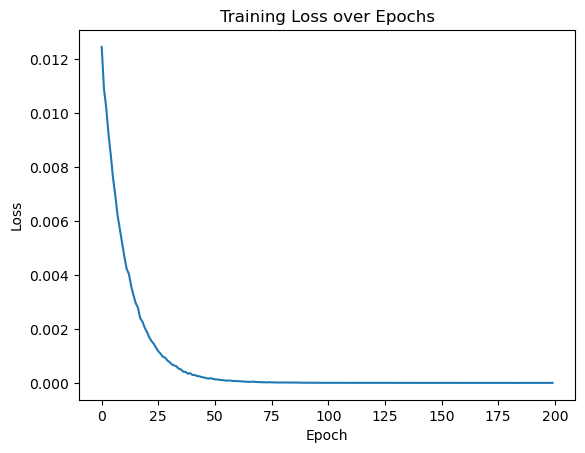

In [8]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(simu_losses)
plt.title('Training Loss over Epochs')
# plt.savefig('fig/0122_abb05_wtconv_loss.png')

In [9]:
# hebbian_update_np = hebbian_update.detach().numpy().flatten()
# plt.plot(np.linspace(0, 2 * np.pi, model.input_size), hebbian_update_np * 0.001)
# # plt.ylim([0,8])
# plt.xlabel("theta")
# plt.ylabel("weight")
# # plt.savefig('abb05_ws.png')
# plt.show()

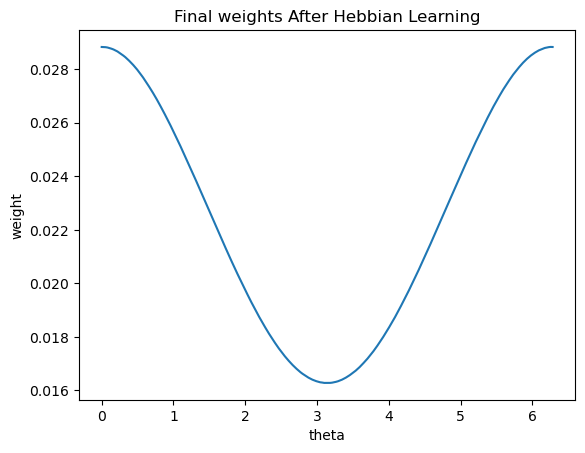

In [10]:
simu_weights = model.weights.detach().numpy().flatten()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), simu_weights)
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
plt.title("Final weights After Hebbian Learning")
# plt.savefig('fig/0122_abb05_wtconv_weights.png')
plt.show()

Text(0.5, 1.0, 'Outputs of the Model')

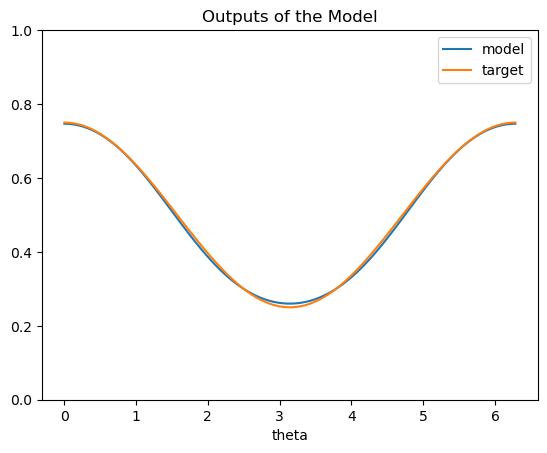

In [11]:
# Plotting the outputs
final_model = SimpleNeuralNetwork(model.input_size, model.init_gain.detach().numpy(), model.init_shift.detach().numpy(), simu_weights)
# final_model.gainout = 6.7
# final_model.shiftout = 1.035
outputs = []
for x in xs:
    output = final_model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
plt.title("Outputs of the Model")
# plt.savefig('fig/0122_abb05_wtconv_output.png')

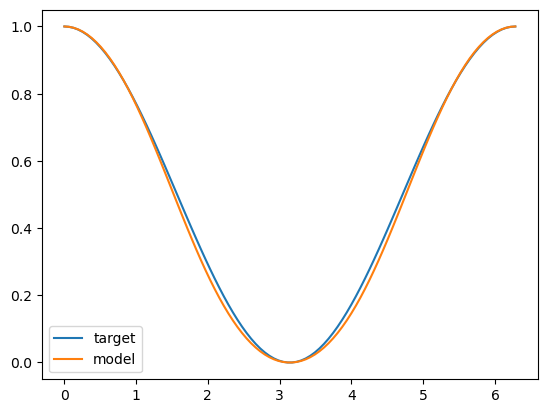

In [12]:
# rescale outputs to 0 and 1
ys_np = ys.detach().numpy()
ys_np = (ys_np - np.min(ys_np)) / (np.max(ys_np) - np.min(ys_np))
plt.plot(xs, ys_np, label='target')

outputs_np = np.array(outputs)
outputs_np = (outputs_np - np.min(outputs_np)) / (np.max(outputs_np) - np.min(outputs_np))
plt.plot(xs, outputs_np, label='model')

plt.legend()

### Thoughts before Feb 2023

It seems that weights have a correct shape. And if you rescale it into 0-1 range, it the output will be perfect.

The problem is always that the weights are not extreme enough. So the output is just not as extreme as the target.

The effect will much better if I train with the y, rather than the output. But this pipeline also determines that the trained weight would not be affected by the output activation function.

So I suspect that the sigmoid output activation function has a problem. Changing it to a linear function will somehow change the effect. Tuning the gain and shift of that sigmoid also has an effect. But both need careful tuning, which doesn't seem quite generalizable.

Also, fewer datapoints might have a better effect especially when training in total. I find a general trend of flattening the weights if we add more datapoints. It has little effect when we do the trining element-wise.

Here is what I am going to try:
1. Look very carefully on the original code. Find how many datapoints he is using, what is the final weights, what is the input activation function and the output activation function. - I checked, still can be more careful, especially about input activation function.
2. To see whether I can do something with the input activation function.
3. Search for something like "convergence of hebbian learning".
4. Try this very simple process with spiking neural network.
5. Tuning the output activation gains and shifts. - Yes, I did this. It works. 6.7 and 1.035.